# GAN trained on MNIST Dataset

In [ ]:
#imports

import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
##########################
### SETTINGS
##########################

# Device
#CUDA_DEVICE_NUM = 3
#DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
print('Device:', DEVICE)

# Hyperparameters
#SEED = 42
GENERATOR_LEARNING_RATE = 0.002
DISCRIMINATOR_LEARNING_RATE = 0.002

NUM_EPOCHS = 20
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 64, 3

Device: cpu


In [ ]:
#import os
#import torch

#os.environ["PL_GLOBAL_SEED"] = str(RANDOM_SEED)
#random.seed(RANDOM_SEED)

#Dataset

In [ ]:
##########################
### Dataset
##########################

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor


customs = torchvision.transforms.Compose([ #We need custom transforms because ToTensor() causes size mismatching
    torchvision.transforms.CenterCrop((160, 160)),
    torchvision.transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



train_dataset = datasets.LFWPeople(root='data',
                               split = 'train',
                               transform= customs, #alternatively, use customs
                               download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])


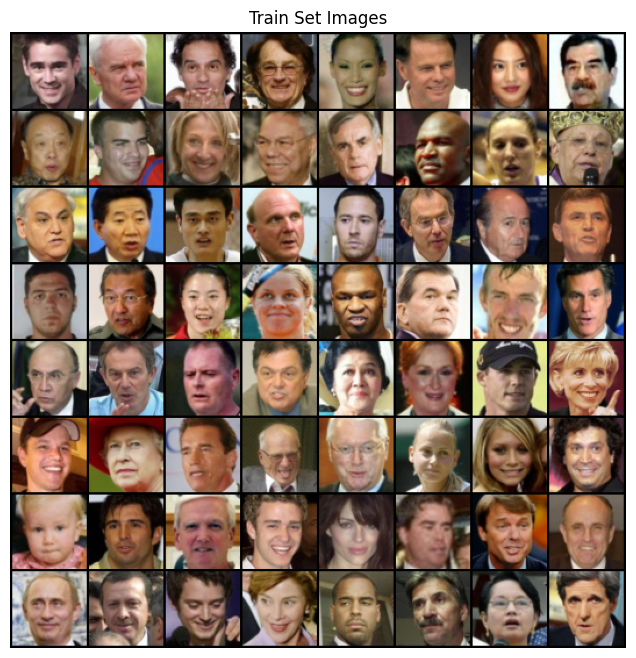

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Train Set Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64],
                                         padding=2, normalize=True),
                        (1, 2, 0)))
plt.show()

#Model

In [ ]:
class DCGAN(torch.nn.Module):

    def __init__(self, latent_dim=100,
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
        super().__init__()


        self.generator = nn.Sequential(

            #We will assume for all dimensions that latent_dim = 100

            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8,
                               kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),

            # 64 * 8 x 4 x 4

            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),

            # 64 * 4 x 8 x 8

            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),

            # 64 * 2 x 16 x 16

            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.LeakyReLU(inplace=True),

            # 64 x 32 x 32

            nn.ConvTranspose2d(num_feat_maps_gen, color_channels,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),

            # 3 x 64 x 64

            nn.Tanh()
        )

        self.discriminator = nn.Sequential(

            # input shape color_channels x image_height x image_width

            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),

            # 64 x 32 x 32

            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),

            # 64 * 2 x 16 x 16

            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),

            # 64 * 4 x 8 x 8

            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),

            # 64 * 8 x 4 x 4

            nn.Conv2d(num_feat_maps_dis*8, 1,
            kernel_size=4, stride=1, padding=0),

            # 1 x 1 x 1
            nn.Flatten(),

        )


    def generator_forward(self, z):
        img = self.generator(z)
        return img

    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits

In [ ]:
#set_all_seeds(RANDOM_SEED)

model = DCGAN()
model.to(DEVICE)

#Adam optimizer. Replace with custom optimizer if need be.
optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [ ]:
#from helper_evaluate import compute_accuracy
#from helper_evaluate import compute_epoch_loss_classifier
#from helper_evaluate import compute_epoch_loss_autoencoder

import time
import torch
import torch.nn.functional as F
import torchvision
import torch.autograd


def train_gan(num_epochs, model, optimizer_gen, optimizer_discr,
                 latent_dim, device, train_loader, loss_fn=None,
                 logging_interval=100,
                 save_model=None):

    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------


            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())

            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d || Batch %03d/%03d || Gen Loss: %.4f || Discr Loss: %.4f'
                       % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        ### Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict

#Training

In [ ]:
log_dict = train_gan(num_epochs=NUM_EPOCHS, model=model,
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE,
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_facegen.pt')

Epoch: 001/020 || Batch 000/075 || Gen Loss: 7.0607 || Discr Loss: 0.7277
Time elapsed: 10.83 min
Epoch: 002/020 || Batch 000/075 || Gen Loss: 5.9308 || Discr Loss: 0.1653
Time elapsed: 21.50 min
Epoch: 003/020 || Batch 000/075 || Gen Loss: 3.7862 || Discr Loss: 0.7179
Time elapsed: 32.11 min
Epoch: 004/020 || Batch 000/075 || Gen Loss: 3.1452 || Discr Loss: 0.4729
Time elapsed: 42.76 min
Epoch: 005/020 || Batch 000/075 || Gen Loss: 1.7728 || Discr Loss: 0.6114
Time elapsed: 53.35 min
Epoch: 006/020 || Batch 000/075 || Gen Loss: 1.4245 || Discr Loss: 0.5321
Time elapsed: 64.02 min
Epoch: 007/020 || Batch 000/075 || Gen Loss: 1.8707 || Discr Loss: 0.3145
Time elapsed: 74.73 min
Epoch: 008/020 || Batch 000/075 || Gen Loss: 2.5487 || Discr Loss: 0.2746
Time elapsed: 85.45 min
Epoch: 009/020 || Batch 000/075 || Gen Loss: 5.6073 || Discr Loss: 0.7378
Time elapsed: 96.22 min
Epoch: 010/020 || Batch 000/075 || Gen Loss: 2.9601 || Discr Loss: 0.3020
Time elapsed: 107.00 min
Epoch: 011/020 || B

#Evaluation

In [ ]:
#Loss plot function with multiple losses
def plot_losses(losses_list, num_epochs,
                averaging_iterations=100, custom_labels_list=None):

    for i,_ in enumerate(losses_list):
        if not len(losses_list[i]) == len(losses_list[0]):
            raise ValueError('All loss tensors need to have the same number of elements.')

    if custom_labels_list is None:
        custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]

    iter_per_epoch = len(losses_list[0]) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)

    for i, minibatch_loss_tensor in enumerate(losses_list):
        ax1.plot(range(len(minibatch_loss_tensor)),
                 (minibatch_loss_tensor),
                  label=f'Minibatch Loss{custom_labels_list[i]}')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Loss')

        ax1.plot(np.convolve(minibatch_loss_tensor,
                             np.ones(averaging_iterations,)/averaging_iterations,
                             mode='valid'),
                 color='black')

    if len(losses_list[0]) < 1000:
        num_losses = len(losses_list[0]) // 2
    else:
        num_losses = 1000
    maxes = [np.max(losses_list[i][num_losses:]) for i,_ in enumerate(losses_list)]
    ax1.set_ylim([0, np.max(maxes)*1.5])
    ax1.legend()

    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())

    plt.tight_layout()

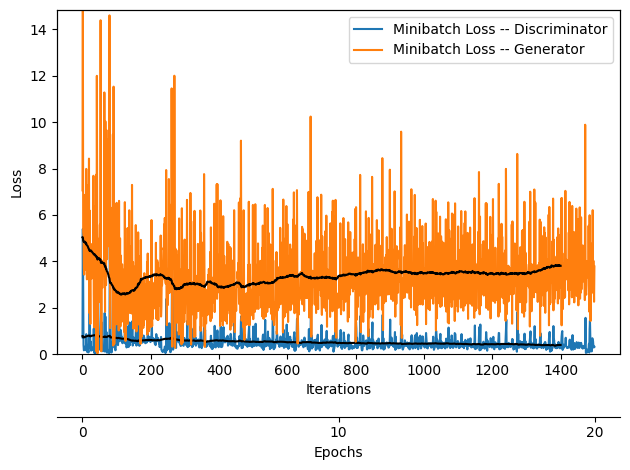

In [ ]:
plot_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS,
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

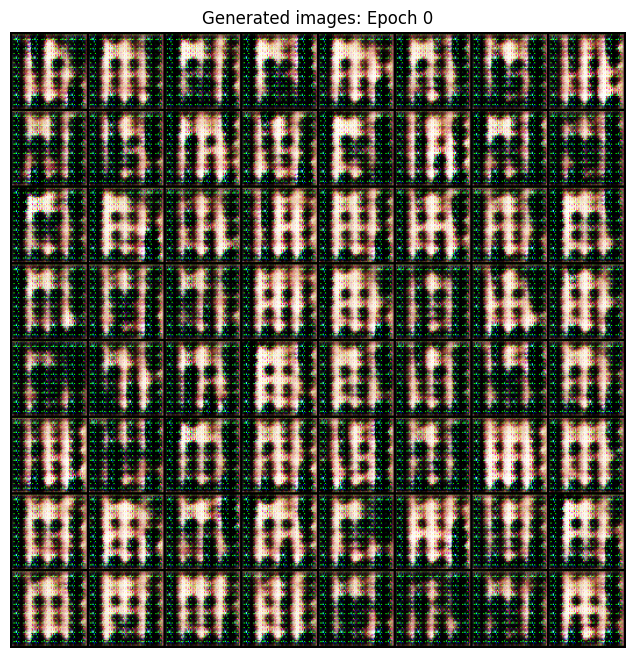

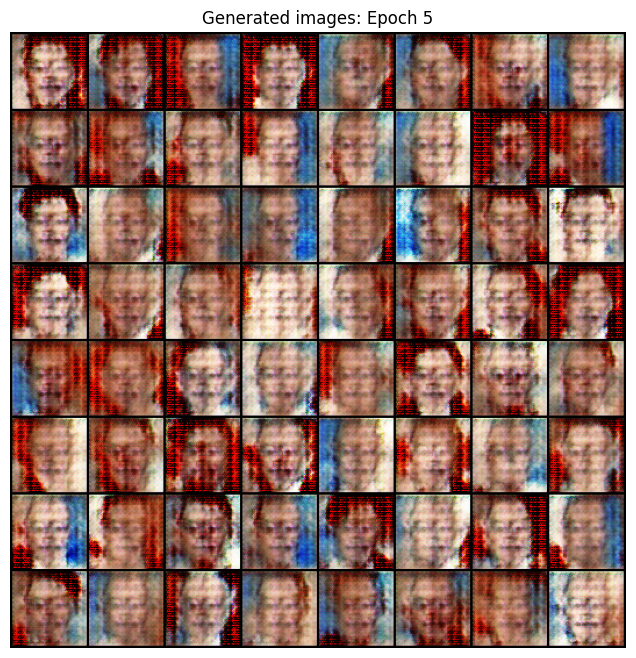

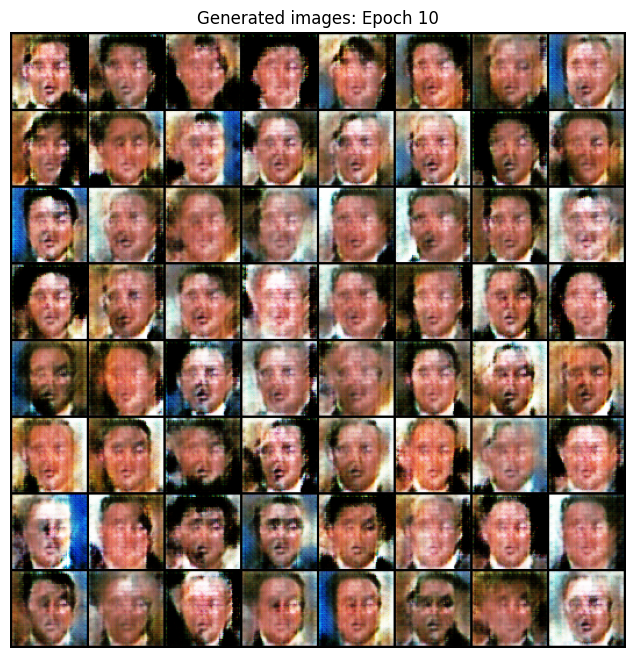

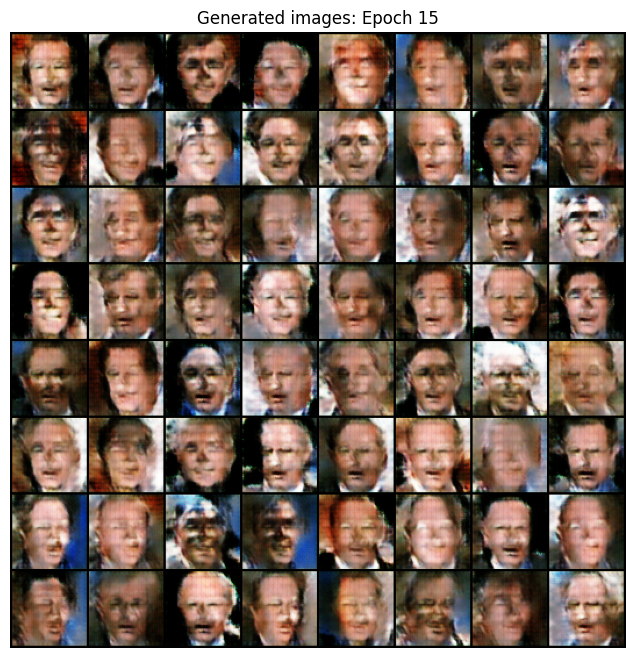

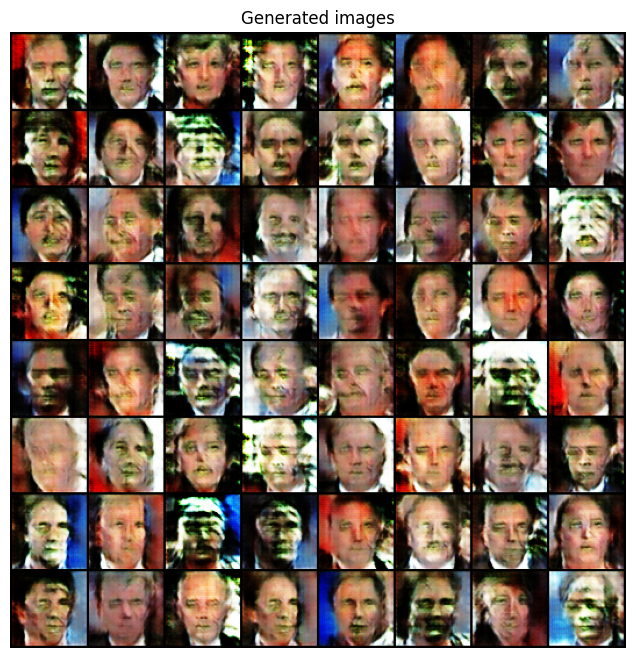

In [ ]:
for i in range(0, NUM_EPOCHS, 5):

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images: Epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()